In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
cd projects/foldtree2

/home/dmoi/projects/foldtree2


In [4]:
import sys
sys.path.append('/home/dmoi/projects/foldtree2')
#read the afdb clusters file
import pandas as pd
import numpy as np
import glob
import os
#autoreload
import pickle
from src import AFDB_tools
import tqdm

In [5]:
datadir = '../../datasets/foldtree2/'

In [6]:

#read the afdb rep file
reps = pd.read_table( datadir + 'afdbclusters/1-AFDBClusters-entryId_repId_taxId.tsv', header=None, names=['entryId', 'repId', 'taxId'] )
print( 'reps' , reps.head() )


reps       entryId       repId    taxId
0  A0A009E921  A0A009E921  1310605
1  A0A009F5K6  A0A009E921  1310605
2  A0A009E9H3  A0A009E9H3  1310605
3  A0A484ZLT0  A0A009E9H3    82979
4  A0A009ECR5  A0A009ECR5  1310605


In [7]:

structs = glob.glob( datadir+'structs/*.pdb' )
#remove the .pdb extension
structs = [ s.split( '/' )[-1].split( '.' )[0] for s in structs ]
print(structs[0:10])

['A0A6A6MTL2', 'S8AHX0', 'A0A3D4Y7U3', 'A0A182QEX7', 'A0A7R8CEM3', 'A0A1B6MIL6', 'A0A4S4D698', 'A0A2X0NIQ0', 'A0A495JSP3', 'A0A3C0CY76']


In [8]:
#select the reps that have structures
reps = reps[ reps['repId'].isin( structs ) ]
print(  len(reps)  , reps.head() )

52310          entryId       repId    taxId
4934  A0A011P981  A0A011P981  1454005
4935  A0A090T2D3  A0A011P981   990271
4936  A0A377ZK61  A0A011P981      574
4937  A0A379ZCQ2  A0A011P981      615
4938  A0A4U9U8T5  A0A011P981    47917


In [11]:
#make a structure alignment directory
if not os.path.exists( 'struct_align' ):
    os.makedirs( 'struct_align' )

#make a directory for each cluster representative
for rep in reps['repId']:
    if not os.path.exists( datadir +'struct_align/' + rep  ):
        os.makedirs(datadir + 'struct_align/' + rep  )
    if not os.path.exists( datadir+ 'struct_align/' + rep  + '/structs/'):
        os.makedirs( datadir+ 'struct_align/' + rep + '/structs/' )
        

In [10]:
#download n struct members for each cluster
dl_structs = False
if dl_structs == True:
    n = 5
    for rep in tqdm.tqdm(reps.repId.unique() ):
        subdf = reps[ reps['repId'] == rep ]
        if len(subdf) < n:
            n = len(subdf)
        subdf = subdf.sample( n = n  )
        subdf = subdf.head( n )
        #download the structures
        for uniID in subdf['entryId']:
            AFDB_tools.grab_struct(uniID , structfolder=datadir+'struct_align/' + rep  + '/structs/')

In [11]:
#for each folder in struct_align, align the structures with all vs all using foldseek
from src import foldseek2tree
aln_structs = False
if aln_structs == True:
    for rep in tqdm.tqdm(reps.repId.unique() ):
        #align the structures
        foldseek2tree.runFoldseek_allvall_EZsearch( infolder= datadir + 'struct_align/' + rep  + '/structs/', outpath=datadir+'struct_align/' + rep + '/allvall.csv' )


In [14]:
import re 
encoded_fasta = '/home/dmoi/projects/foldtree2/structalign.strct.fasta' 

start = '//////startprot//////.*//////'
#re containing wildcards
start_re = re.compile( start )
stop = '//////endprot//////'
#re containing wildcards
stop_re = re.compile( stop )
seqstr = ''
seqdict = {}
ID = ''
with open(encoded_fasta, 'r') as f:
    #read all chars of file into a string
    for line in tqdm.tqdm(f):
        if '//////startprot//////' in line:
            seqstr = ''
            ID = line.split( '//////' )[2].split('/')[-1]
        elif '//////contacts//////' in line:
            seqdict[ID] = seqstr
        else:
            #include carriage returns
            seqstr += line+'\n'
encoded_df = pd.DataFrame( seqdict.items() , columns=['protid', 'seq'] )
#change index to protid
encoded_df.index = encoded_df.protid
encoded_df = encoded_df.drop( 'protid', axis=1 )
print(encoded_df)

28it [00:00, 47240.75it/s]

                                                              seq
protid                                                           
A0A0B0EGE4.pdb  [ttO{{»»»»»»»»ââââââââââââââââââââââââââ[[[[[[...
A0A6M1Q9D4.pdb  [ttO{{»»»»»»»»ââââââââââââââââââââââââââ[[[[[[...
A0A7W6LMN5.pdb  [ttO{{»»»»»»»»ââââââââââââââââââââââââââ[[[[[[...
A0A090ZGQ5.pdb  [ttO{{»»»»»»»»ââââââââââââââââââââââââââ[[[[[[...


In [16]:

charset = 365
#get the character for newline
replace = ord('\n')
print(replace)
replacement = chr(365)
print(replacement)
encoded_df.seq = encoded_df.seq.apply( lambda x: x.replace('\n',chr(replacement)) )


10
ŭ


In [ ]:


cols = 'query,target,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,qaln,taln'.split(',')
alnfiles = glob.glob(datadir + 'struct_align/*/allvall.csv')


submat =  np.zeros((charset,charset))
pdbfiles_structalign = glob.glob('./struct_align/*/structs/*.pdb')

for rep in tqdm.tqdm(alnfiles ):
    #load the all vs all aln
    aln_df = pd.read_table(rep)
    aln_df.columns = cols
    #load the embedding of the structures
    q = aln_df['query'].unique()
    t = aln_df['target'].unique()
    representative = rep.split('/')[-2]
    for q in aln_df['query'].unique():
        for t in aln_df['target'].unique():
            if q != t:
                #align the structures
                aln = aln_df[ (aln_df['query'] == q) & (aln_df['target'] == t) ]
                qaln = aln.qaln
                taln = aln.taln
                if q in encoded_df.index and t in encoded_df.index:
                    qz = iter(encoded_df.loc[q].seq)
                    tz = iter(encoded_df.loc[t].seq)
                    #transfer the alignments to the embeddings
                    qaln_ft2 = [ ord(next(qz)) if x != '-' else None for x in iter(qaln) ]
                    taln_ft2 = [ ord(next(tz)) if x != '-' else None for x in iter(taln) ]
                    alnzip = zip( qaln_ft2 , taln_ft2 )
                    alnzip = [ [a[0] , a[1]] for a in alnzip if a[0] is not None and a[1] is not None]
                    submat[alnzip] += 1


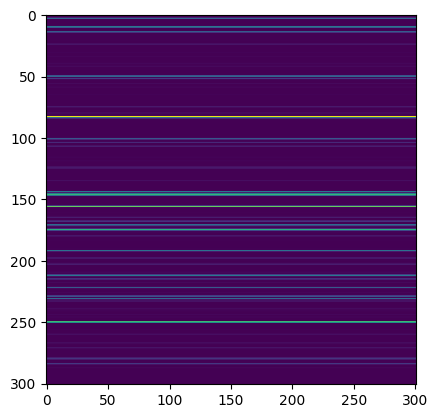

In [52]:
from matplotlib import pyplot as plt
plt.imshow(submat)

In [ ]:
#mafft matrix file example max 248 char
"""
0x01 0x01 2   # (comment)
0x1e 0x1e 2
0x1f 0x1f 2
0x21 0x21 2   # ! × !
0x41 0x41 2   # A × A
0x42 0x42 2   # B × B
0x43 0x43 2   # C × C
"""

def output_mafft_matrix( submat , outpath='mafft_submat.mtx' ):
    with open(outpath, 'w') as f:
        for i in range(submat.shape[0]):
            for j in range(submat.shape[1]):
                if i >= j:
                    hexi = hex(i)
                    hexj = hex(j)
                    stringi = chr(i)
                    stringj = chr(j)
                    f.write( f'{hexi} {hexj} {submat[i,j]} # ' stringi + 'x' + stringj + ' \n' )


In [ ]:
#align the structures
# mafft --textmatrix maff_submat.mtx input > output

In [ ]:
#iqtree matrix file example 
"""   A   C   G   T   X
A  0   1   2   1   0.5
C  1   0   1   2   0.2
G  2   1   0   1   0.3
T  1   2   1   0   0.1
X  0.5 0.2 0.3 0.1  0
"""

def output_iqtree_matrix( submat , outpath='iqtree_submat.mtx' ):
    #write out distmat in phylip compatible format
    init = ' '.join( [ char(i) for i in range(submat.shape[0]) ] )
    with open(outpath, 'w') as f:
        f.write( init + '\n' )
        for i in range(submat.shape[0]):
    		outstr += char(i) + ' ' + ' '.join( [ "{:.4f}".format(d) for d in list( distmat[i,: ] )  ]  ) + '\n'
       handle.write(outstr)
 	return outpath

In [ ]:

#save the submats in raw form
for charset in charsets:
    np.save( 'submats/' + str(charset) + '.npy' , submats[charset] )
    with open( 'submats/' + str(charset) + '.txt' , 'w' ) as f:
        for i in range( charset ):
            f.write( '\t'.join( [ str(submats[charset][i,j]) for j in range( charset ) ] ) + '\n' )

#normalize the submats rows and columns to sum to 1
for charset in charsets:
    rowsums = submats[charset].sum( axis=1 )
    colsums = submats[charset].sum( axis=0 )
    for i in range( charset ):
        submats[charset][i,:] = submats[charset][i,:] / rowsums[i]
        submats[charset][:,i] = submats[charset][:,i] / colsums[i]

#save the submats in normalized form
for charset in charsets:
    np.save( 'submats/' + str(charset) + '_norm.npy' , submats[charset] )
    with open( 'submats/' + str(charset) + '_norm.txt' , 'w' ) as f:
        for i in range( charset ):
            f.write( '\t'.join( [ str(submats[charset][i,j]) for j in range( charset ) ] ) + '\n' )
    



In [ ]:
#make tree
#iqtree -s example.fasta -m ./iqtree_submat.mtx+I+F

#reconstruct
#iqtree -s example.fasta -m ./iqtree_submat.mtx+I+F -t treefile.tree -asr


In [ ]:
#pass the asr through the decoder to get ancestral AA sequences

#fold the amino acid asr and decoded asr into 3d structures using alphafold

#compare plddts
